In [2]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


import scipy as sp
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_log_error


sys.path.append("../")
sys.path.append("../source_code")

print(f"Tensorflow version {tf.__version__}")

Tensorflow version 2.5.0


In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [4]:
train_df['date_time'] = pd.to_datetime(train_df['date_time'])
test_df['date_time'] = pd.to_datetime(test_df['date_time'])

In [5]:
# Feature engineering
train_df['year'] = train_df['date_time'].dt.year
train_df['month'] = train_df['date_time'].dt.month
train_df['hour'] = train_df['date_time'].dt.hour
train_df['day'] = train_df['date_time'].dt.day

test_df['year'] = test_df['date_time'].dt.year
test_df['month'] = test_df['date_time'].dt.month
test_df['hour'] = test_df['date_time'].dt.hour
test_df['day'] = test_df['date_time'].dt.day

In [6]:
train = train_df.set_index("date_time").copy()
test = test_df.set_index("date_time").copy()

In [7]:
target_columns = [col for col in train.columns if col.startswith('target')]
feature_columns = [col for col in train.columns if col not in target_columns]

TEST_PERCENT = 0.1
test_point = np.round(len(train)*TEST_PERCENT)
test_idx = int(len(train) - test_point)

TARGET_IDX = 0
BATCH_SIZE = 1
LENGTH = 48


In [8]:
X_train = train.drop(target_columns, axis=1).iloc[:test_idx,:]
X_test = train.drop(target_columns, axis=1).iloc[test_idx:,:]

y_train = train[target_columns[TARGET_IDX]].iloc[:test_idx]
y_test = train[target_columns[TARGET_IDX]].iloc[test_idx:]

In [9]:
N_FEATURES = X_train.shape[1]

In [10]:
def plot_predictions(y_true: pd.Series, y_pred: pd.Series, length: int):
    plt.figure(figsize=(20,5))
    sns.lineplot(x=y_true[length:].index, y=y_true[length:],label="True labels")
    sns.lineplot(x=y_true[length:].index, y=y_pred.reshape(-1), label="Predictions")
    plt.title(f"Prediction for {y_true.name} RMSLE={np.sqrt(mean_squared_log_error(y_true[length:], np.abs(y_pred.reshape(-1))))}")
    plt.legend()

## Preprocessing

In [11]:
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from pickle import dump
dump(scaler, open('scaler.pkl', 'wb'))

In [13]:
train_generator = TimeseriesGenerator(
    data=X_train_scaled,
    targets = y_train,
    length = LENGTH,
    batch_size = BATCH_SIZE,
)

In [14]:
test_generator = TimeseriesGenerator(
    data=X_test_scaled,
    targets = y_test,
    length = LENGTH,
    batch_size = BATCH_SIZE,
)

In [15]:
train_generator.data[0]

array([0.26339286, 0.45299145, 0.27507135, 0.52241144, 0.37336222,
       0.3967721 , 0.50400271, 0.44674518, 0.        , 0.        ,
       0.7826087 , 0.3       ])

In [16]:
X_train_scaled[0]

array([0.26339286, 0.45299145, 0.27507135, 0.52241144, 0.37336222,
       0.3967721 , 0.50400271, 0.44674518, 0.        , 0.        ,
       0.7826087 , 0.3       ])

# Modelling

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
tf.random.set_seed(1)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Simple LSTM

In [19]:
model = Sequential()
model.add(LSTM(LENGTH, activation='relu', input_shape=(LENGTH, N_FEATURES)))
model.add(Dense(1))
model.compile(optimizer='adam', loss = 'mse')

2021-07-27 22:50:30.253338: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48)                11712     
_________________________________________________________________
dense (Dense)                (None, 1)                 49        
Total params: 11,761
Trainable params: 11,761
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.fit_generator(train_generator, epochs=10, validation_data = test_generator, callbacks = [early_stop])

/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-07-27 22:50:38.154865: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


6352/6352 [==============================] - 62s 10ms/step - loss: 0.8321 - val_loss: 1.7137


<AxesSubplot:>

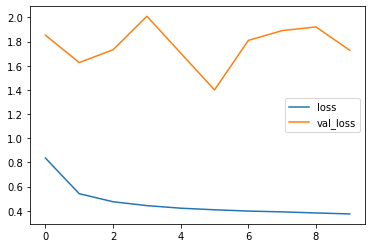

In [32]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

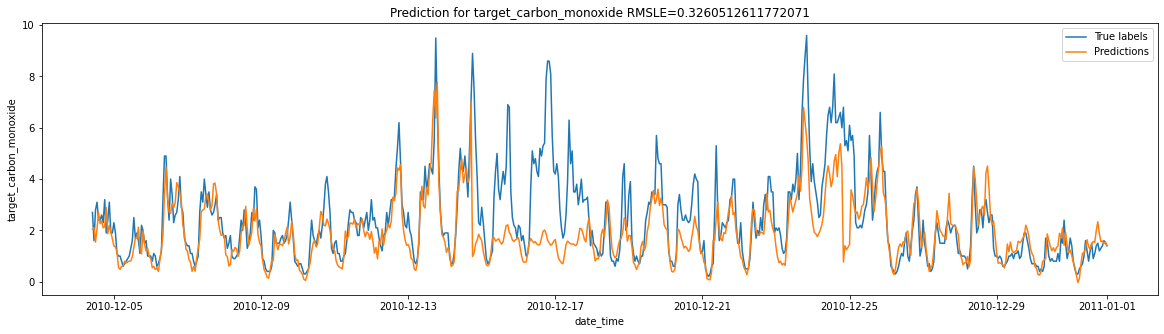

In [33]:
preds = model.predict(test_generator)
plot_predictions(y_test, preds, LENGTH)

### Save model

In [1]:
model.save('lstm_model')
model.save('lstm_model.h5') # HDF5

NameError: name 'model' is not defined

# Simple RNN

In [104]:
model = Sequential()
model.add(SimpleRNN(LENGTH, input_shape = (LENGTH, N_FEATURES)))
model.add(Dense(LENGTH))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [105]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 48)                2928      
_________________________________________________________________
dense_4 (Dense)              (None, 48)                2352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 49        
Total params: 5,329
Trainable params: 5,329
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.fit_generator(train_generator, epochs=10, validation_data = test_generator, callbacks = [early_stop])

/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
6352/6352 [==============================] - 28s 4ms/step - loss: 0.7425 - val_loss: 1.8507
Epoch 2/10
6352/6352 [==============================] - 28s 4ms/step - loss: 0.6294 - val_loss: 1.6567
Epoch 3/10
6352/6352 [==============================] - 27s 4ms/step - loss: 0.6097 - val_loss: 1.7478
Epoch 4/10
6352/6352 [==============================] - 27s 4ms/step - loss: 0.5875 - val_loss: 1.5754
Epoch 5/10
6352/6352 [==============================] - 27s 4ms/step - loss: 0.5503 - val_loss: 1.5677
Epoch 6/10
6352/6352 [==============================] - 27s 4ms/step - loss: 0.5686 - val_loss: 1.4464
Epoch 7/10
6352/6352 [==============================] - 27s 4ms/step - loss: 0.5463 - val_loss: 1.6235
Epoch 8/10
6352/6352 [==============================] - 27s 4ms/step - loss: 0.5017 - val_loss: 1.5214
Epoch 9/10
6352/6352 [==============================] - 27s 4ms/step - loss: 0.4937 - val_loss: 1.6402
Epoch 10/10
6352/6352 [==============================] - 29s 4ms/step - l

<AxesSubplot:>

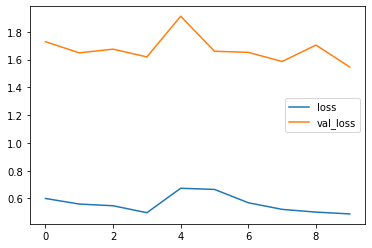

In [112]:
losses = pd.DataFrame(rnn_model.history.history)
losses[['loss','val_loss']].plot()

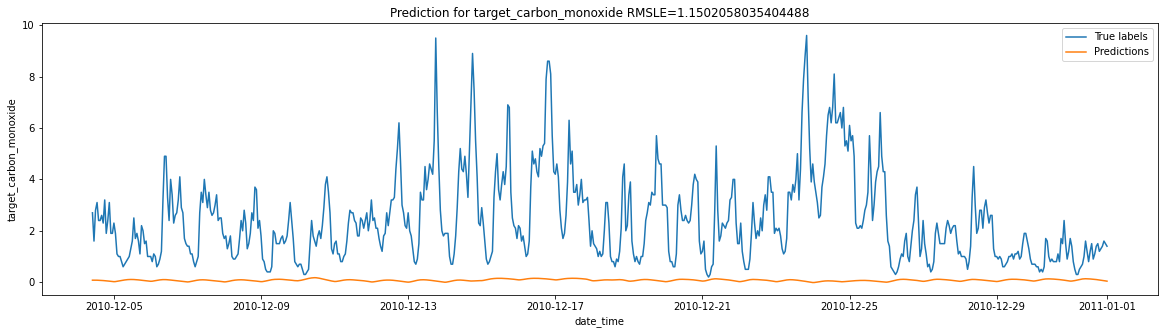

In [113]:
preds = model.predict(test_generator)
plot_predictions(y_test, preds, LENGTH)

# Stacked LSTM

In [114]:
model = Sequential()
model.add(LSTM(LENGTH, return_sequences=True, input_shape=(LENGTH, N_FEATURES), dropout=0.2))
model.add(LSTM(LENGTH))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [115]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 48, 48)            11712     
_________________________________________________________________
lstm_7 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 49        
Total params: 30,385
Trainable params: 30,385
Non-trainable params: 0
_________________________________________________________________


In [116]:
model.fit_generator(train_generator, epochs=5, validation_data = test_generator, callbacks = [early_stop])


/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
6352/6352 [==============================] - 126s 19ms/step - loss: 1.0557 - val_loss: 2.2621
Epoch 2/5
6352/6352 [==============================] - 125s 20ms/step - loss: 0.7522 - val_loss: 1.7750
Epoch 3/5
6352/6352 [==============================] - 124s 19ms/step - loss: 0.6855 - val_loss: 1.7111
Epoch 4/5
6352/6352 [==============================] - 124s 20ms/step - loss: 0.6728 - val_loss: 1.5760
Epoch 5/5
6352/6352 [==============================] - 126s 20ms/step - loss: 0.6297 - val_loss: 1.8353


<AxesSubplot:>

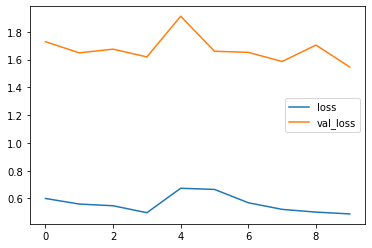

In [117]:
losses = pd.DataFrame(rnn_model.history.history)
losses[['loss','val_loss']].plot()

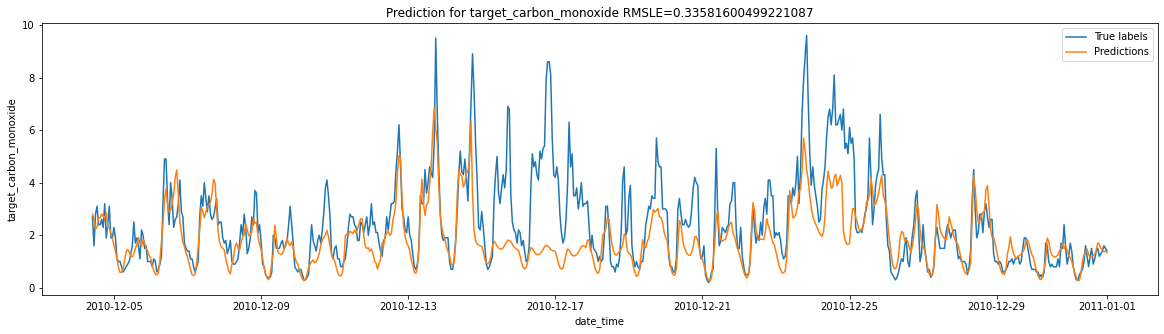

In [118]:
preds = model.predict(test_generator)
plot_predictions(y_test, preds, LENGTH)

# LSTM + Autoencoder

In [121]:
weights_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1., seed=45)

In [122]:
def rmsle_custom(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred))


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_rmsle_custom', 
                                      mode='min',patience=4, 
                                      restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', # val_rmsle_custom try
                                               mode='min',
                                               patience=2, 
                                               verbose=1)

In [128]:
model = Sequential([
    LSTM(LENGTH, return_sequences=True, input_shape = (LENGTH, N_FEATURES), kernel_initializer=weights_initializer),
    LSTM(int(LENGTH/2), return_sequences=True, kernel_initializer=weights_initializer),
    LSTM(int(LENGTH/4), kernel_initializer=weights_initializer),
    RepeatVector(LENGTH),
    LSTM(int(LENGTH/4), return_sequences=True, kernel_initializer=weights_initializer),
    LSTM(int(LENGTH/2), return_sequences=True, kernel_initializer=weights_initializer),
    LSTM(LENGTH, return_sequences=True,  kernel_initializer=weights_initializer),
    TimeDistributed(Dense(N_FEATURES)),
])
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.mean_squared_error,
    metrics=rmsle_custom
)



In [130]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 48, 48)            11712     
_________________________________________________________________
lstm_23 (LSTM)               (None, 48, 24)            7008      
_________________________________________________________________
lstm_24 (LSTM)               (None, 12)                1776      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 48, 12)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 48, 12)            1200      
_________________________________________________________________
lstm_26 (LSTM)               (None, 48, 24)            3552      
_________________________________________________________________
lstm_27 (LSTM)               (None, 48, 48)           

In [ ]:
model.fit_generator(train_generator, epochs=25, validation_data = test_generator, callbacks = [plateau, early_stop])


/Users/jeremy/.virtualenvs/kaggle-competitions/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
6352/6352 [==============================] - 375s 58ms/step - loss: 2.0580 - rmsle_custom: 0.3646 - val_loss: 3.1947 - val_rmsle_custom: 0.3765
Epoch 2/5
6352/6352 [==============================] - 357s 56ms/step - loss: 2.0373 - rmsle_custom: 0.3629 - val_loss: 3.0391 - val_rmsle_custom: 0.3716
Epoch 3/5
4184/6352 [==================>...........] - ETA: 1:53 - loss: 1.9798 - rmsle_custom: 0.3596

In [ ]:
losses = pd.DataFrame(rnn_model.history.history)
losses[['loss','val_loss']].plot()

In [ ]:
preds = model.predict(test_generator)
plot_predictions(y_test, preds, LENGTH)